# **Neuroevolution**


In [17]:
%pip install numpy matplotlib scipy

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import gymnasium as gym

The CartPole environment hasa 4-dimensional continous observation space consisting of the cart's position, the cart's velocity, the pole's angle, and the pole's angular velocity. These values represent real number within specific ranges, such as +-4.8 units for the cart position and +-0.418 radians for the pole angle, while velocities are theoretically unbounded. The action space is discrete with a single dimension, allowing two possible actions: 0 to push the cart to the left and 1 to push it to the right. Thusi the ANN will take a continuous 4D input and produce a discrete binary output indicating the direction of the applied force.

My proposed ANN architecture for this task is a feedforward neural network with one hidden layer. The network takes a 4D input corresponding to the CartPole observation space and passes it through a hidden layer with 8 neurons using the ReLU activation function, which is efficient and helps avoid vanishing gradient issues. The output layer has 1 neuron that produces a continous value, which is then thresholded to choose between the two possible actions (left or right). The simplicity of this architecture allows fast evaluation and is sufficient for the relatively low-dimensional CartPole control task.

In [18]:
inp = 4 # Number of input neurons
hid = 8 # Number of hidden neurons
out = 1 # Nubmer of output neurons

#Open AI gym environment
env = gym.make("CartPole-v1")

# CartPole evaluation function
def cartpole(x):

    # Extracting ANN weights from individual x
    W1 = x[:inp * hid].reshape(hid,inp)
    b1 = x[inp*hid : inp * hid + hid]
    W2 = x[inp * hid + hid : -out].reshape(out,hid)
    b2 = x[-out:]

    # Reset environment
    observation, info = env.reset(seed = 0)

    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step<1000:
      h = np.maximum(0,np.dot(W1,observation)+b1) #ReLU
      output = np.dot(W2,h) + b2
      action = int(output.item() > 0)


      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward

    env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)



# CartPole evaluation function with video recording
def cartpole_record_video(x):
    tmp_env = gym.make("CartPole-v1", render_mode="rgb_array")

    # Video recording function - be sure to check the folder path - you should see the video here:content/video/cartpole
    env = gym.wrappers.RecordVideo(env=tmp_env, video_folder="content/video/cartpole", name_prefix="cartpole")

    # Extracting ANN weights from x same as above
    W1 = x[:inp * hid].reshape(hid,inp)
    b1 = x[inp*hid : inp * hid + hid]
    W2 = x[inp * hid + hid : -out].reshape(out,hid)
    b2 = x[-out:]



    # Reset environment
    observation, info = env.reset(seed = 0)

    #env.start_video_recorder()


    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step<1000: # run nStep number of time

      h = np.maximum(0,np.dot(W1,observation)+b1) #ReLU
      output = np.dot(W2,h) + b2
      action = int(output.item() > 0)

      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward
      env.render()

    #env.close_video_recorder()
    env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)




# CartPole evaluation function for visualizing the cartpole environment
def cartpole_visualize(x):
    tmp_env = gym.make("CartPole-v1", render_mode="human")

    # Extracting ANN weights from x same as above
    W1 = x[:inp * hid].reshape(hid,inp)
    b1 = x[inp*hid : inp * hid + hid]
    W2 = x[inp * hid + hid : -out].reshape(out,hid)
    b2 = x[-out:]

    # Reset environment
    observation, info = tmp_env.reset(seed = 0)

    rew = 0 # Initial reward
    step = 0; #step counter
    done = False
    maxStep = 1000  # maximum number of steps
    while not done and step<1000: # run nStep number of time
      h = np.maximum(0,np.dot(W1,observation)+b1) #ReLU
      output = np.dot(W2,h) + b2
      action = int(output.item() > 0)

      # action should be provided based on the output of the artifial neural network
      observation, reward, done, tr, info = tmp_env.step(action)
      step+=1 # step counter
      rew = rew + reward # after each step increment reward
      tmp_env.render()

    tmp_env.close()
    return np.minimum(maxStep, rew) # return the reward or maxStep (if maxStep < 1000, this means that pole fell)


def ea(
    # hyperparameters of the algorithm
    population_size,
    max_fit_evals,  # Maximum number of evaluations
    p_crossover,  # Probability of performing crossover operator
    m_rate,  # mutation rate
    objective_function,  # objective function to be minimized
):
    # Total weights and biases
    genome_length = inp*hid + hid + hid*out + out

    # Initializing the population
    population = np.random.randn(population_size, genome_length)
    fitness = np.array([objective_function(ind) for ind in population])
    evals = population_size

    f_best = []
    x_best = [population[np.argmax(fitness)]]

    while evals < max_fit_evals:
      # Selecting parents with roulette wheel method
      probs = fitness / fitness.sum()
      parents_idx = np.random.choice(population_size, size = population_size, p=probs)
      parents = population[parents_idx]

      offspring = []
      for i in range(0, population_size,2):
        p1 = parents[i]
        p2 = parents[(i+1) % population_size]
        # Crossover
        if np.random.rand() < p_crossover:
          alpha = np.random.rand()
          c1 = alpha * p1 + (1-alpha) * p2
          c2 = alpha * p2 + (1-alpha) * p1
        else:
          c1,c2 = p1.copy(), p2.copy()
        offspring.extend([c1,c2])

      offspring = np.array(offspring[:population_size]) # if the size is odd

      # Mutation
      for i in range(population_size):
        mutation_mask = np.random.rand(genome_length) < m_rate
        mutation_values = np.random.normal(0,0.1,genome_length)
        offspring[i] += mutation_mask * mutation_values

      # Evaluating offspring
      fitness_offspring = np.array([objective_function(ind) for ind in offspring])
      evals += population_size

      # Selecting survivors by keeping the best individuals
      combined = np.vstack([population, offspring])
      combined_fitness = np.concatenate([fitness, fitness_offspring])
      best_indices = np.argsort(combined_fitness)[-population_size:]
      population = combined[best_indices]
      fitness = combined_fitness[best_indices]

      # Saving the current best
      best_idx = np.argmax(fitness)
      x_best = [population[best_idx]]
      f_best.append(fitness[best_idx])

    return x_best, f_best  # return the best solution (ANN weights) and the fitness in each generation

In [19]:
kwargs = {
    "population_size": 50,
    "max_fit_evals": 10000,  # maximum number of fitness evaluations
    "p_crossover": 0.9,  # crossover probability
    "m_rate": 0.02,  # mutation rate
    "objective_function": cartpole,
}
# Run your algorithm once and find the best ANN weigths found
env = gym.make("CartPole-v1")
x_best, f_best = ea(**kwargs)


# Print the best ANN weigths found and best fitness
print("Best ANN parameters found:",x_best[-1])
print("Best fitnes found:",f_best[-1])


# Evaluate your ANN weights again and record the video
if f_best[-1] >= 1000:
  cartpole_record_video(x_best[-1] )
  #cartpole_visualize(x_best[-1] )
else:
  print("The best fitness 1000 was not found, try again!!")

KeyboardInterrupt: 

**Results from a previous run:**

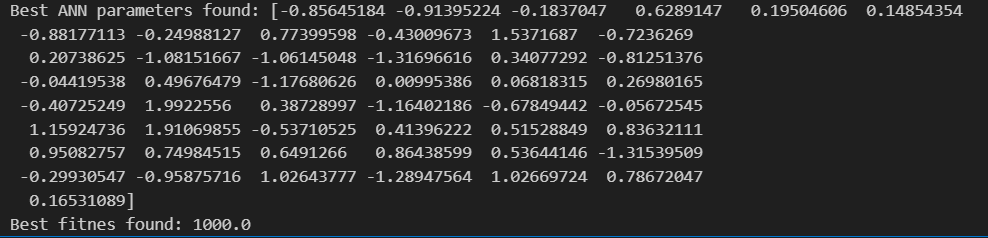

In [ ]:
kwargs = {
    "population_size": 50,
    "max_fit_evals": 10000,
    "p_crossover": 0.9,
    "m_rate": 0.02,
    "objective_function": cartpole,
}

# Running the EA multiple times
num_runs = 10
all_fitness = []

for run in range(num_runs):
  print(f"Run {run+1}/{num_runs}")
  _, f_best = ea(**kwargs)
  all_fitness.append(f_best)

fig,axs = plt.subplots(2,5,figsize=(20,8))
fig.suptitle("Best Fitness per Generation for Each of the 10 EA Runs")

for i, fitness in enumerate(all_fitness):
  row = i//5
  col = i%5
  axs[row,col].plot(fitness, color='blue')
  axs[row,col].set_title(f"Run {i+1}")
  axs[row,col].set_xlabel("Generation")
  axs[row,col].set_ylabel("Best Fitness")
  axs[row,col].set_ylim(0, 1050)
  axs[row,col].grid(True)

plt.tight_layout(rect = [0,0,1,0.95])
plt.show()

**Results of a previous run:**
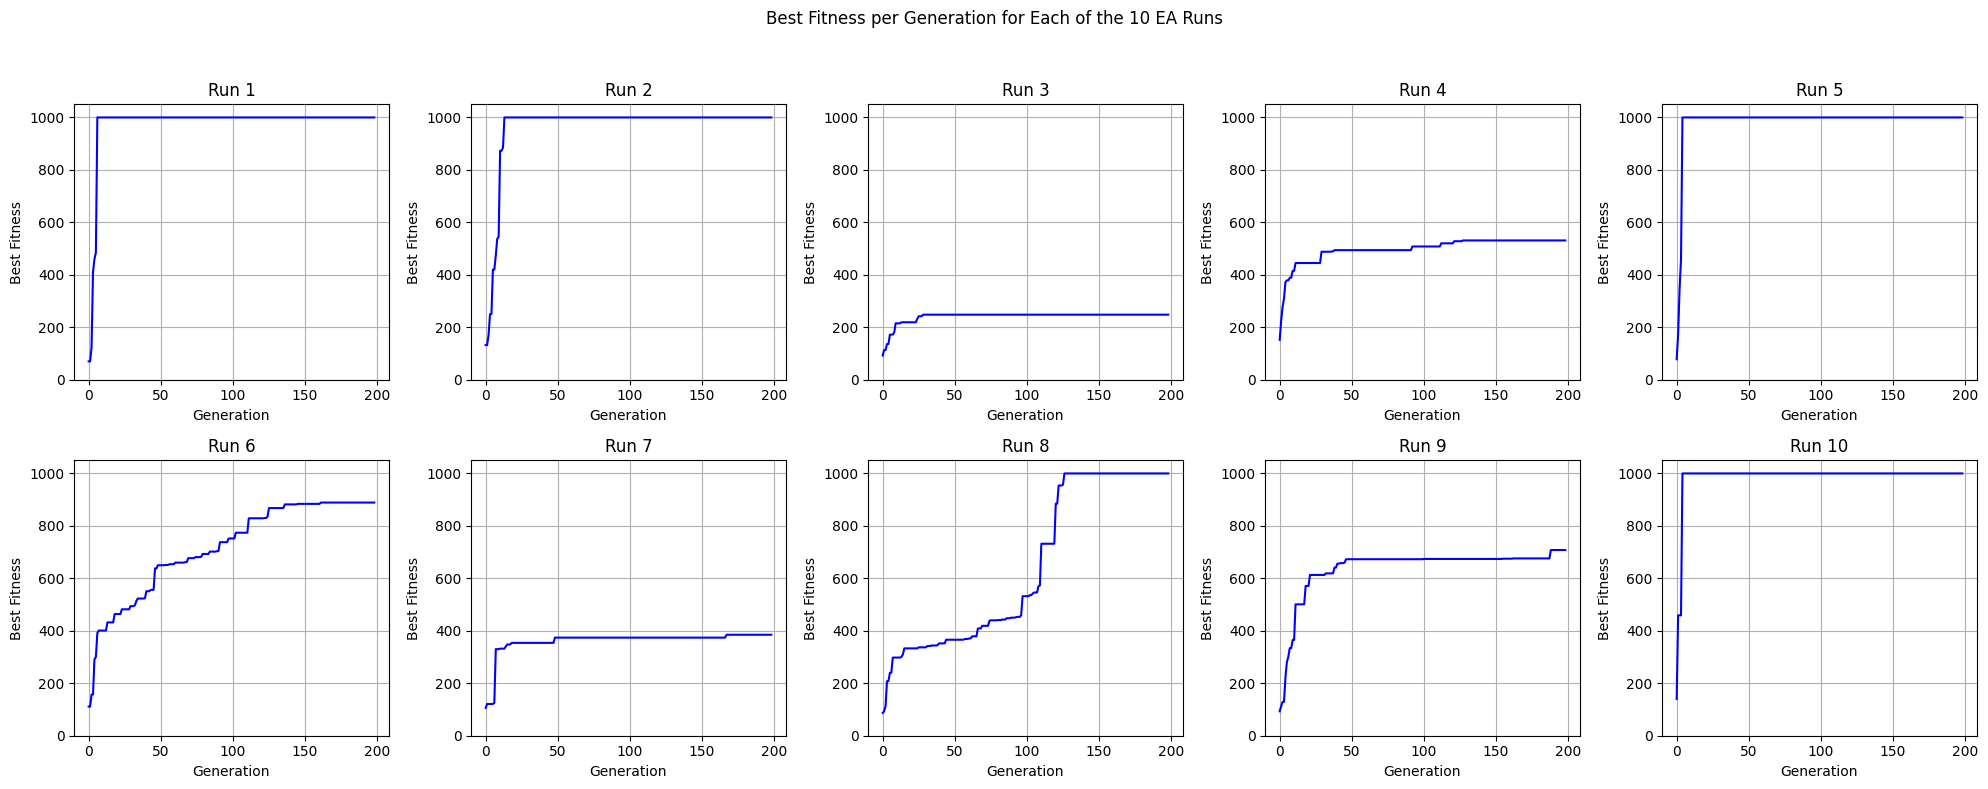

The convergence plots demonstrate that the algorithm exhibits consistent improvement in best fitness values over generations across multiple runs. In several runs (e.g. 1,2,5,10) the algorithm rapidly converges to the optimal fitness value of 1000 within the first 25-30 generations, indicating fast and effective learning of ANN weights. Other runs (e.g. 6,8,9) show slower convergence, requiring more generations to reach high performance, while some (e.g. 3,7) appear to stagnate early and fail to reach optimal fitness within the allowed evaluations. This variability is expected due to the stochastic nature of evolutionary algorithms. Overall, the results show that the algorithm often converges successfully but not consistently in every run, highlighting the importance of running the EA multiple times to ensure robustness.